# Pneumonia X-Ray Analysis

**Author:** Marina Saito
***

## Overview and Business Problem

Pneumonia is typically caused by a viral or bacterial infection in the lungs.  Using chest x-rays, radiologists typically look for white spots in the lungs to identify the infection.  A classification model that could assess the likelihood that a patient has pneumonia could alert radiologists to the possibility or likelihood of pneumonia so that they could analyze the image more carefully to reduce human error in identifying cases of pneumonia.

It is important not to misclassify patients with pneumonia (i.e., to minimize false negatives).  Therefore, I will focus on the recall score in evaluating my models.

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import glob
from PIL import Image, ImageStat

# Modeling Imports
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('../../src')
import functions as fx

In [2]:
# Import Data
train_path = '../../chest_xray/train'
test_path = '../../chest_xray/test'
val_path = '../../chest_xray/val'
train_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(train_path, target_size = (256, 256), 
                         batch_size = 32, class_mode = 'binary')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (256, 256), 
                         batch_size = 32, class_mode = 'binary')
val_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(val_path, target_size = (256, 256), 
                         batch_size = 32, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Note:
- The validation set only includes 16 images
- To improve cross-validation, I randomly selected and moved 100 images from the test set to the validation set
- To review how I moved the images, see my [Create New Split Notebook](../exploratory/create_new_split.ipynb)

## Data Understanding

### Visual Inspection

Below are multiple examples comparing the x-rays of a normal patient (left) to the x-rays of a patient with pneumonia (right):

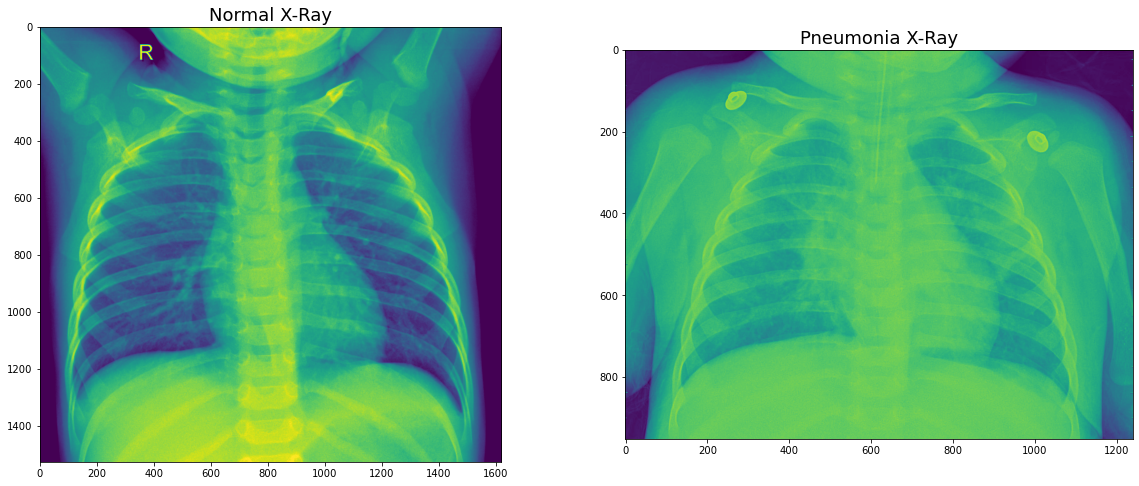

In [3]:
fx.compare_xrays()

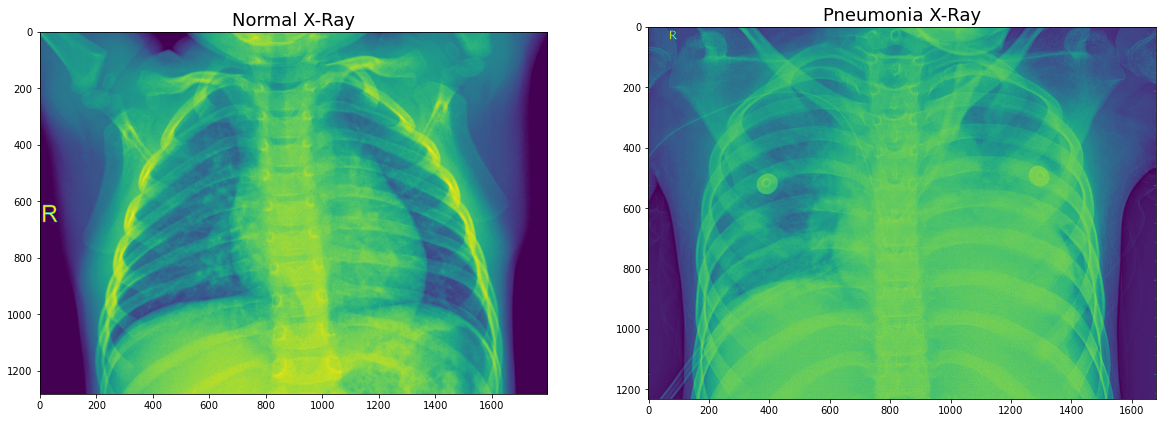

In [4]:
fx.compare_xrays()

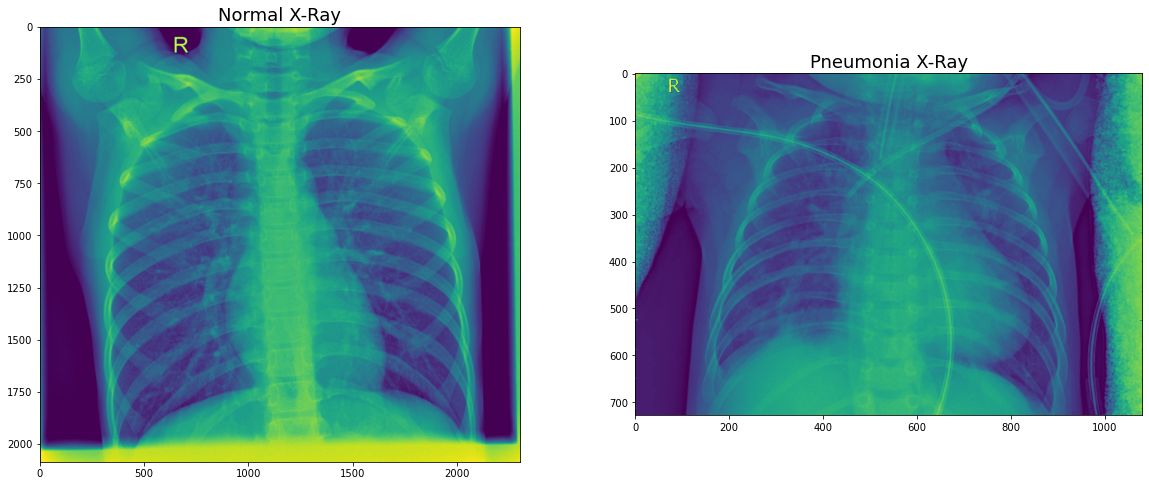

In [5]:
fx.compare_xrays()

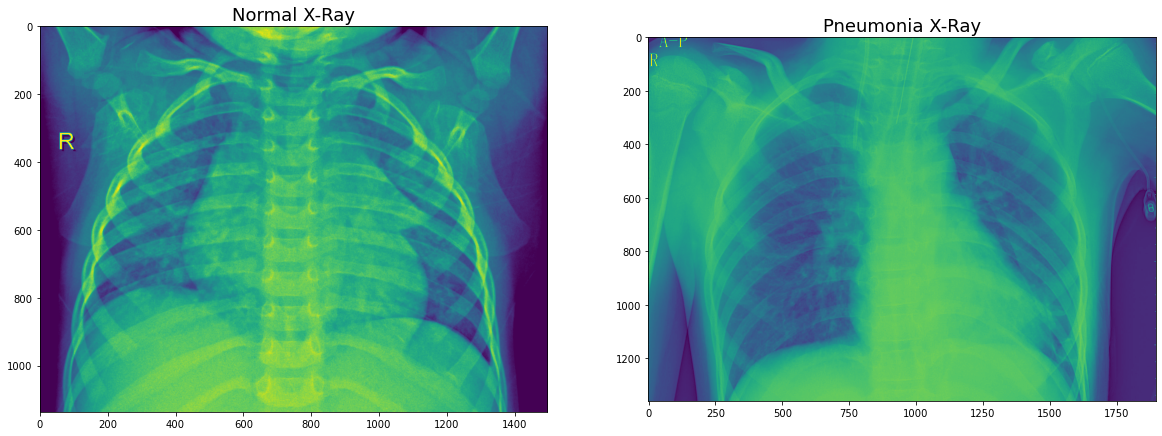

In [6]:
fx.compare_xrays()

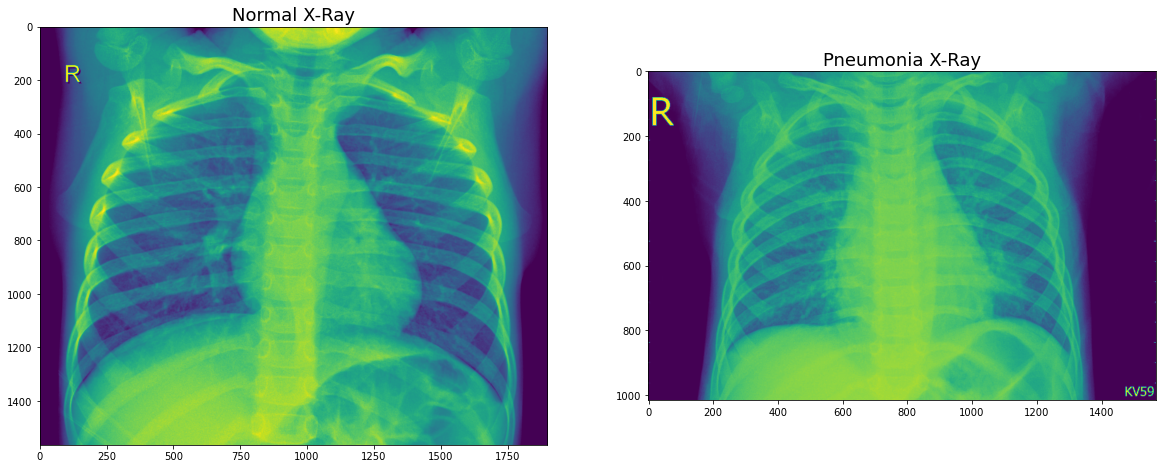

In [49]:
fx.compare_xrays()

It is very difficult to distinguish the x-rays in the patients with pneumonia (right) from the x-rays of the normal patients.  Some subtle differences (which may or may not be relevant) are that the lungs in the patients with pneumonia appear slightly hazier than the lungs of the normal patients.  In addition, the heart appears to have a clear outline in the normal patients, where the outline is not as defined in the patients with pneumonia.

### Image Brightness

Below, I compare the distributions of the brightness levels in the x-rays to determine whether there is a difference between x-rays of normal patients and x-rays of patients with pneumonia.

In [9]:
def brightness(im_file):
    im = Image.open(im_file).convert('L')
    stat = ImageStat.Stat(im)
    return stat.mean[0]

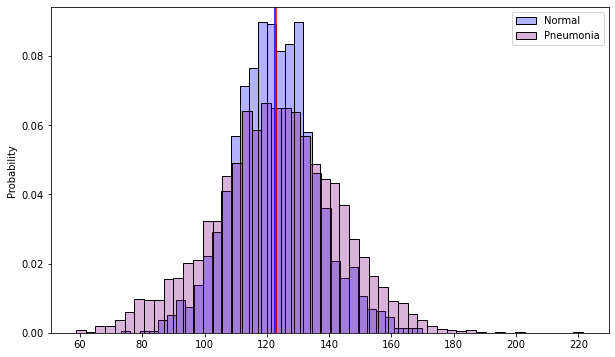

In [10]:
# Calculate brightness for normal x-rays
brightness_normal = []
for filename in glob.glob(train_path + '/NORMAL/*.jpeg'):
    brightness_normal.append(brightness(filename))
for filename in glob.glob(test_path + '/NORMAL/*.jpeg'):
    brightness_normal.append(brightness(filename))
for filename in glob.glob(val_path + '/NORMAL/*.jpeg'):
    brightness_normal.append(brightness(filename))

# Calculate brightness for pneumonia x-rays
brightness_pneumonia = []
for filename in glob.glob(train_path + '/PNEUMONIA/*.jpeg'):
    brightness_pneumonia.append(brightness(filename))
for filename in glob.glob(test_path + '/PNEUMONIA/*.jpeg'):
    brightness_pneumonia.append(brightness(filename))
for filename in glob.glob(val_path + '/PNEUMONIA/*.jpeg'):
    brightness_pneumonia.append(brightness(filename))

# Plot distributions
plt.figure(figsize=(10,6))
sns.histplot(brightness_normal, stat = 'probability', 
             label = 'Normal', color = 'blue', alpha = 0.3)
plt.axvline(x = np.mean(brightness_normal), color = 'blue')
sns.histplot(brightness_pneumonia, stat = 'probability', 
             label = 'Pneumonia', color = 'purple', alpha = 0.3)
plt.axvline(x = np.mean(brightness_pneumonia), color = 'red')
plt.legend()
plt.savefig('../../reports/figures/brightness_compare')
plt.show();

As shown above, the average brightness of the normal x-rays aligns with the average brightness of the pneunomia x-rays; however, the distribution of the brightness of the pneumonia x-rays is wider than the distribution of the brightness of the normal x-rays.

### Data Imbalance
Below is a plot displaying the number of normal x-rays in the training data compared to the number of pneumonia x-rays:

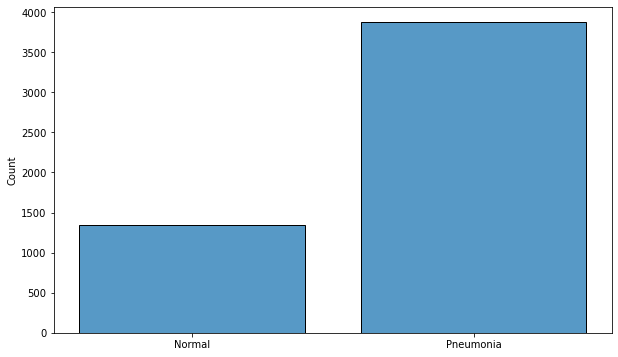

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(np.where(train_generator.classes > 0.5, 
                      'Pneumonia', 'Normal'), shrink = 0.8);

Because the number of pneumonia x-rays far exceeds the number of normal x-rays in the training data, there is a bias toward the majority class (i.e., the pneumonia class).  To account for this imbalance, I will set the class weights applied to the data during training.

In [12]:
# Calculate weights to balance normal and pneumonia data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

## Data Preparation

Because the training of convolutional neural networks improves with the amount of data used to train the model, I will use data augmentation to artificially expand the size of the training data set.  The lungs in the x-ray images extend relatively close to the edges of the x-ray, so I will limit shifting the images in both the vertical and horizontal direction and the zoom into the image to 0.1.  I also will include a horizontal_flip and a rotation range of 30 degrees to augment the images.

In [13]:
# Reload test and validation data after shift
train_path = '../../chest_xray/train'
test_path = '../../chest_xray/new_test'
val_path = '../../chest_xray/new_val'
# Include data augmentation with training data, and 
train_generator = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 30, 
                                     zoom_range = [0.9, 1.2],
                                     width_shift_range = 0.1, 
                                     height_shift_range = 0.1,
                                     horizontal_flip = True) \
    .flow_from_directory(train_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')
val_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(val_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


## Model Development

Initially I ran two very simple models: one baseline model with a single hidden layer, and one convolutional neural network with a single hidden layer.  To review the simple models, please review my [Simple Model notebook](../exploratory/simple_models.ipynb).

I then tried various classic algorithms on the data to determine which provided the best predictions on the data.  To review the analysis on the classic algorithms, please review my [Classic Architectures notebook](../exploratory/classic_architectures.ipynb).
  
I found that LeNet5 performed best on the data.  I therefore used LeNet5 as a basis for my models.  To review my modeling process, please review my [Build Models Notebook](../exploratory/build_models.ipynb).

### Final Model
- Started with LeNet5
- Replaced AveragePooling2D after convolutional layers with MaxPooling2D and BatchNormalization
- Dropped 50% of the input units before every dense layer
- Replaced ReLU activation functions with LeakyReLU

In [14]:
def final_model(image):
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(16, (5, 5), activation = LeakyReLU()),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(120, activation = LeakyReLU()),
        Dropout(0.5),
        Dense(82, activation = LeakyReLU()),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', 
                  metrics=['accuracy', 'Recall'])
    return model

In [15]:
model = final_model(train_generator[0][0][0])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 6)       456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 6)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 6)       24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 16)      2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 16)        64        
_________________________________________________________________
flatten (Flatten)            (None, 59536)             0

2021-10-24 08:05:56.878498: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Note:
- Included an early stop if the validation loss increased for over 5 epochs

In [16]:
early_stop_loss = EarlyStopping(monitor = 'val_loss', 
                                min_delta = 0.01, patience = 5, 
                                mode = 'min', restore_best_weights = True)

In [17]:
result = model.fit(train_generator, epochs = 20, 
                   validation_data=val_generator, 
                   class_weight = train_class_weights, 
                   callbacks = [early_stop_loss])

2021-10-24 08:06:07.343847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
82/82 [==============================] - 127s 2s/step - loss: 1.6279 - accuracy: 0.7985 - recall: 0.8000 - val_loss: 3.9606 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 2/20
82/82 [==============================] - 132s 2s/step - loss: 1.1651 - accuracy: 0.8426 - recall: 0.8415 - val_loss: 7.6750 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 3/20
82/82 [==============================] - 140s 2s/step - loss: 1.0252 - accuracy: 0.8480 - recall: 0.8477 - val_loss: 6.0065 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 4/20
82/82 [==============================] - 136s 2s/step - loss: 0.7967 - accuracy: 0.8528 - recall: 0.8537 - val_loss: 7.9195 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 5/20
82/82 [==============================] - 134s 2s/step - loss: 0.6860 - accuracy: 0.8656 - recall: 0.8650 - val_loss: 4.6317 - val_accuracy: 0.6034 - val_recall: 1.0000
Epoch 6/20
82/82 [==============================] - 139s 2s/step - loss: 0.5753 - accuracy: 0.8698 - reca

## Results
- The model stopped training after 13 epochs
- As depicted below, the model does not fit the validation data as well as the training data

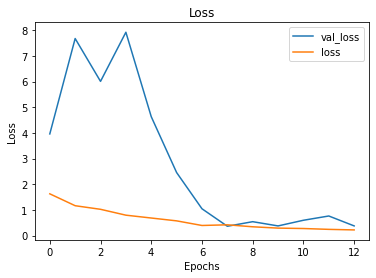

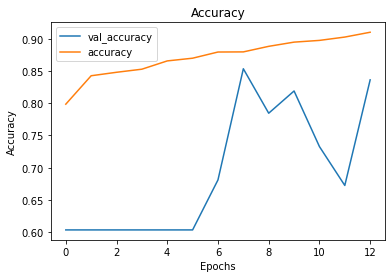

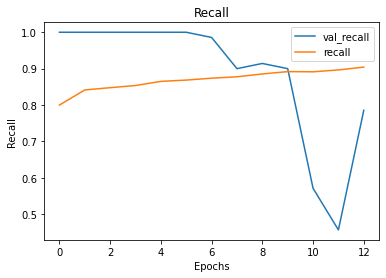

In [43]:
fx.visualize_training_results(result)

In [39]:
fx.get_metrics(model, train_generator)

Accuracy: 0.6144555214723927
Recall: 0.7220645161290322


In [40]:
fx.get_metrics(model, val_generator)

Accuracy: 0.5431034482758621
Recall: 0.6428571428571429


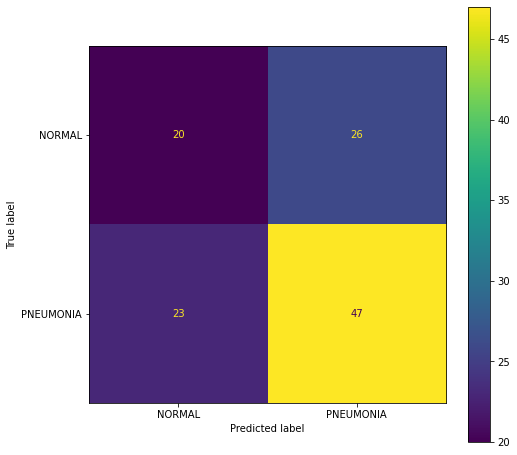

In [19]:
fx.create_confusion_matrix(model, val_generator)

### Lime
- I implemented a package called [lime](https://github.com/marcotcr/lime) (local interpretable model-agnostic explanations) to illustrate the areas on the x-rays that the model focuses on to classify an x-ray as normal or as pneumonia
- Lime highlights in the images below pros (evidence of pneumonia) in green and cons (evidence of not pneumonia) in red
- Unfortunately, the model does not focus solely on the lungs in to classify whether a patient has pneumonia or not

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

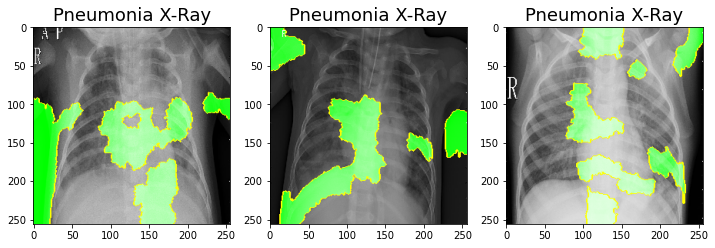

In [41]:
fx.display_lime(model, val_generator)

### Lime
- I also used lime to plot explanation weights onto a heatmap visualization
- The lime heatmap also confirms that my model is not focusing solely on the lungs to classify whether a patient has pneumonia or not

  0%|          | 0/1000 [00:00<?, ?it/s]

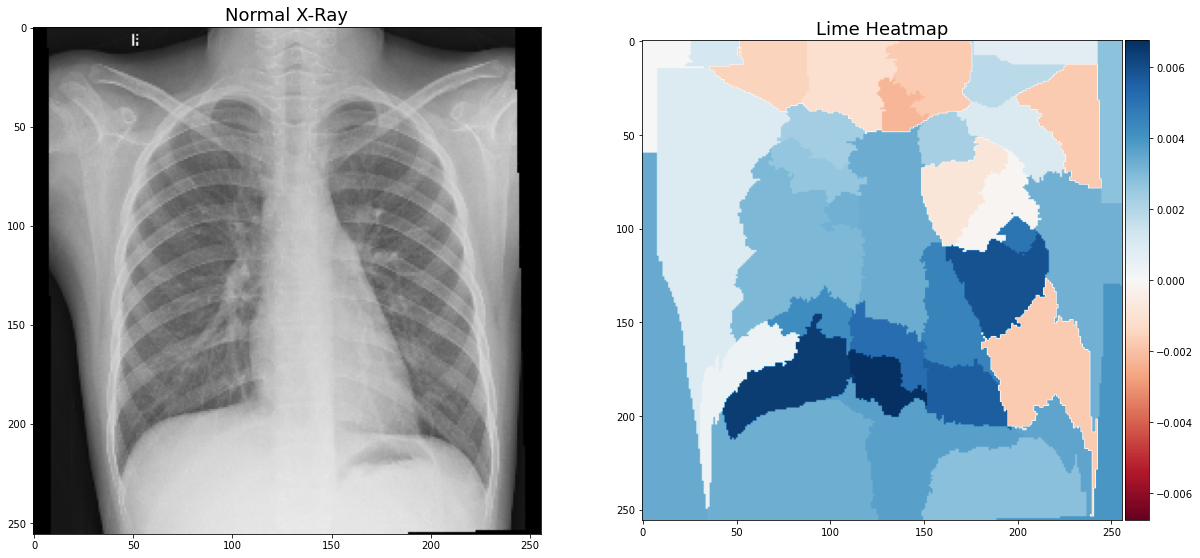

In [21]:
fx.run_lime_heatmap(model, val_generator)

### Lime
- Similar images have been created for the test data

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

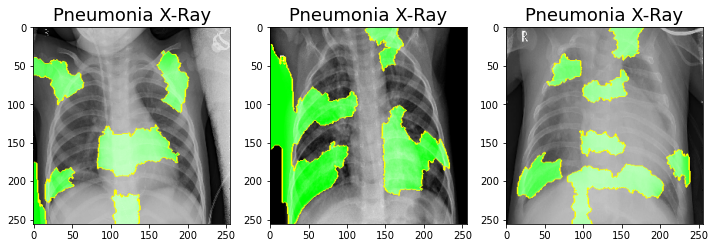

In [48]:
fx.display_lime(model, test_generator)

  0%|          | 0/1000 [00:00<?, ?it/s]

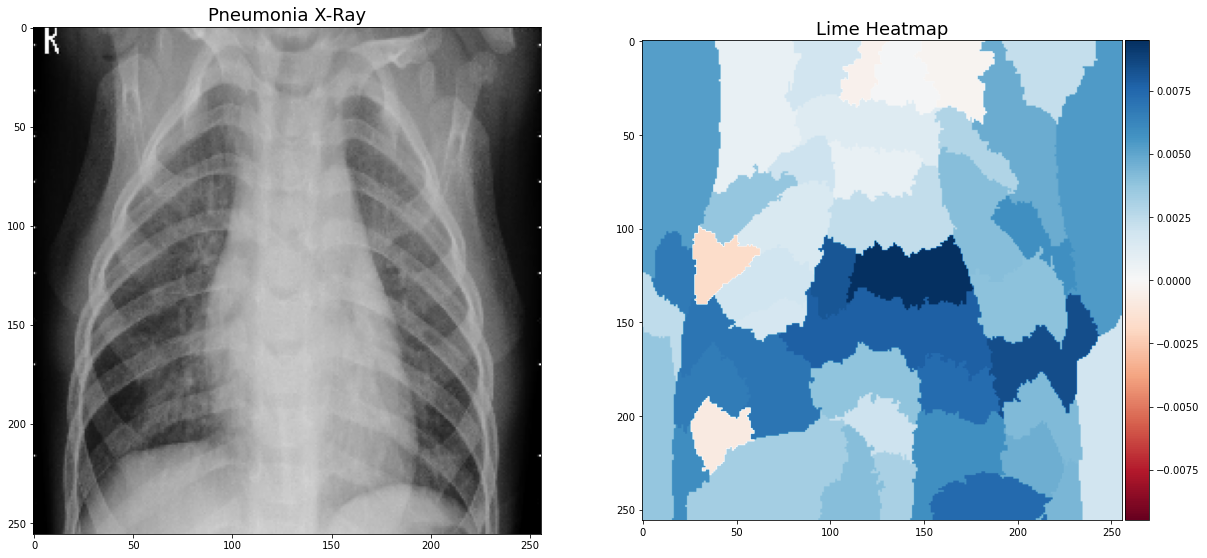

In [45]:
fx.run_lime_heatmap(model, test_generator)

### Results on Test Data
- The metrics below indicate 54% accuracy and a 65% recall score on the test data

In [46]:
fx.get_metrics(model, test_generator)

Accuracy: 0.5362595419847328
Recall: 0.6463414634146342


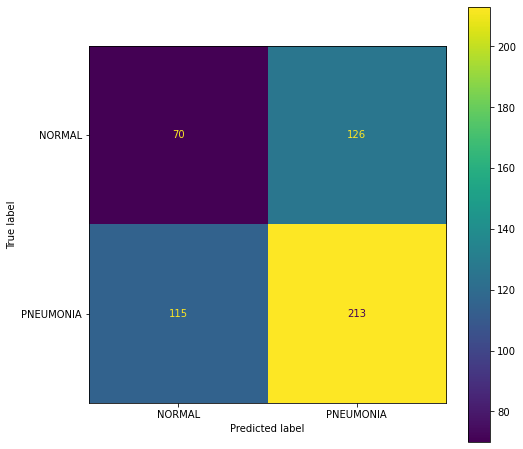

In [47]:
fx.create_confusion_matrix(model, test_generator)

## Save final model

In [36]:
model.save('../../model/final_model.h5')

## Conclusion
- I created a convolutional neural network model that classifies x-rays of patients with pneumonia.
- The model is not performing very well
    - The accuracy of the model is only at 54% with a recall of 65% 
    - The model is not classifying the images by focusing solely on the lungs
- Though the model is not performing very well, I have created the tools to monitor the performance of the model during training, and to determine what portions of the x-ray the model is focusing on to perform the classification

## Next Steps
- Continue adjusting model parameters to improve model classification